Notebook for training a 3D U-Net for vestibular schwannoma segmentation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [3]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Load the data. 

In [4]:
mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset.npy"
masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset.npy"


mris = np.load(mris_path)
masks = np.load(masks_path)



In [5]:
mris.shape

(242, 64, 64, 64)

In [6]:
masks.shape

(242, 64, 64, 64)

Normalise the data. 

In [7]:
# def normalize_3d_image(img):
#     return (img - img.min()) / (img.max() - img.min())


def standardize_3d_image(img):
    """
    Standardize a 3D image using Z-score normalization.

    Parameters:
    - img: 3D numpy array representing the MRI image.

    Returns:
    - standardized_img: 3D numpy array representing the standardized MRI image.
    """
    mean = np.mean(img)
    std = np.std(img)
    standardized_img = (img - mean) / std
    return standardized_img

In [8]:
print(np.min(mris))
print(np.max(mris))

0.0
4093.7407


In [9]:
for i in range(mris.shape[0]): 
    mris[i] = standardize_3d_image(mris[i])

In [10]:
print(np.min(mris))
print(np.max(mris))

-0.9647217
11.05375


Split the data into training and test sets. 

In [11]:
# Create an array of indices corresponding to the original dataset
indices = np.arange(len(mris))

X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    mris, masks, indices, test_size=0.20, shuffle=True, random_state=SEED
)

In [12]:


print(
    f"Training data\nDimensions: {X_train.shape}\nMax-value: {np.max(X_train)}\nMin-value: {np.min(X_train)}"
)
print(
    f"Test data\nDimensions: {X_test.shape}\nMax-value: {np.max(X_test)}\nMin-value: {np.min(X_test)}"
)


Training data
Dimensions: (193, 64, 64, 64)
Max-value: 11.053750038146973
Min-value: -0.9647216796875
Test data
Dimensions: (49, 64, 64, 64)
Max-value: 10.367440223693848
Min-value: -0.9305791854858398


Build the model. 

In [13]:
model = sm.Unet(
    "resnet34",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS),
    encoder_weights=None,
    activation="sigmoid",
)


dice_loss = sm.losses.DiceLoss()
bce_loss = sm.losses.BinaryCELoss()
total_loss = dice_loss + bce_loss


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=total_loss,
    metrics=[sm.metrics.IOUScore()],
)


cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_iou_score", mode="max", patience=10, restore_best_weights=True
)


Train the model. 

In [14]:
history = model.fit(
    X_train, Y_train, epochs=100, batch_size=8, validation_split=0.20, callbacks=[cb]
)

Epoch 1/100
20/20 [==============================] - 47s 1s/step - loss: 1.3362 - iou_score: 3.3726e-04 - val_loss: 1.2525 - val_iou_score: 2.9624e-10
Epoch 2/100
20/20 [==============================] - 19s 945ms/step - loss: 1.0401 - iou_score: 0.0021 - val_loss: 1.1996 - val_iou_score: 3.7221e-10
Epoch 3/100
20/20 [==============================] - 19s 936ms/step - loss: 0.9953 - iou_score: 0.0126 - val_loss: 2.1927 - val_iou_score: 5.8609e-11
Epoch 4/100
20/20 [==============================] - 20s 987ms/step - loss: 0.9271 - iou_score: 0.0420 - val_loss: 1.0657 - val_iou_score: 2.3953e-08
Epoch 5/100
20/20 [==============================] - 19s 959ms/step - loss: 0.6960 - iou_score: 0.1924 - val_loss: 1.9542 - val_iou_score: 0.0015
Epoch 6/100
20/20 [==============================] - 19s 959ms/step - loss: 0.3818 - iou_score: 0.4663 - val_loss: 1.1061 - val_iou_score: 0.0109
Epoch 7/100
20/20 [==============================] - 19s 949ms/step - loss: 0.3045 - iou_score: 0.5338 - va

Evaluate the model. 

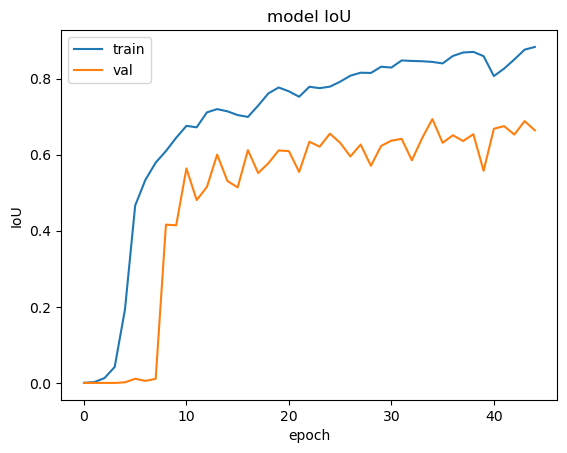

In [15]:
plt.plot(history.history["iou_score"])
plt.plot(history.history["val_iou_score"])
plt.title("model IoU")
plt.ylabel("IoU")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [16]:
def getScore(predictions, test_mask):
    intersection = np.logical_and(test_mask, predictions)
    dice_score = (np.sum(intersection) * 2) / (np.sum(predictions) + np.sum(test_mask))

    return dice_score


# Loop through each item, predict, and calculate scores

dice_scores = []

for i in range(X_test.shape[0]):
    single_item = np.expand_dims(X_test[i], axis=0)
    pred = model.predict(single_item)
    pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
    Y_test_single = Y_test[i]
    dice_score = getScore(pred_t, Y_test_single)

    dice_scores.append(dice_score)

# Calculate average scores

print(f"Dice for the whole test set: {round(np.average(dice_scores),3)}")

1/1 [==============================] - 0s 34ms/step
Dice for the whole test set: 0.71


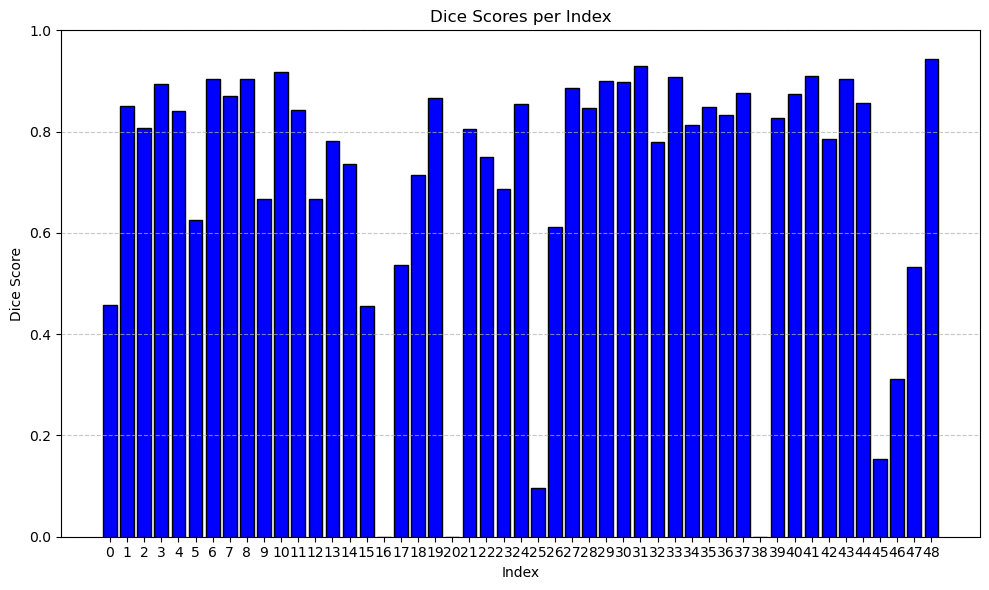

In [17]:
# Generate indices for x-axis
indices = list(range(len(dice_scores)))

plt.figure(figsize=(10, 6))
plt.bar(indices, dice_scores, color="blue", edgecolor="black")
plt.xlabel("Index")
plt.ylabel("Dice Score")
plt.title("Dice Scores per Index")
plt.xticks(indices)  # This ensures every index is shown on the x-axis
plt.ylim(0, 1)  # Assuming dice score is between 0 and 1
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
def plot_test_image_with_contours(index, X_test, Y_test):
    """
    Plots multiple slices of a 3D test image with annotated and predicted contours in the same figure.

    Parameters:
    - index: Index of the test image to plot.
    - X_test: Array of test images.
    - Y_test: Array of annotated masks/lines.
    """

    # Extract the specified test image and its corresponding masks
    img = X_test[index]
    annotated_mask = Y_test[index]

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(X_test[index, ...], axis=0))
    predicted_mask_t = predicted_mask > 0.5
    slice_indices = [
        i for i in range(img.shape[2]) if np.sum(annotated_mask[:, :, i]) > 0
    ]

    num_slices = len(slice_indices)
    plt.figure(figsize=(5, 5 * num_slices))

    for i, idx in enumerate(slice_indices):
        plt.subplot(num_slices, 1, i + 1)  # Create a subplot for each slice

        # Display the test image slice
        plt.imshow(img[:, :, idx], cmap="gray")

        # Display the annotated contour (in green color) for the slice
        plt.contour(annotated_mask[:, :, idx], colors="g", linewidths=0.5)

        # Display the predicted contour (in red color) for the slice
        plt.contour(
            predicted_mask_t[0, :, :, idx, 0], colors="r", linewidths=0.5
        )  

        plt.title(f"Slice {idx} with Annotated (Green) and Predicted (Red) Contours")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




1/1 [==============================] - 0s 37ms/step


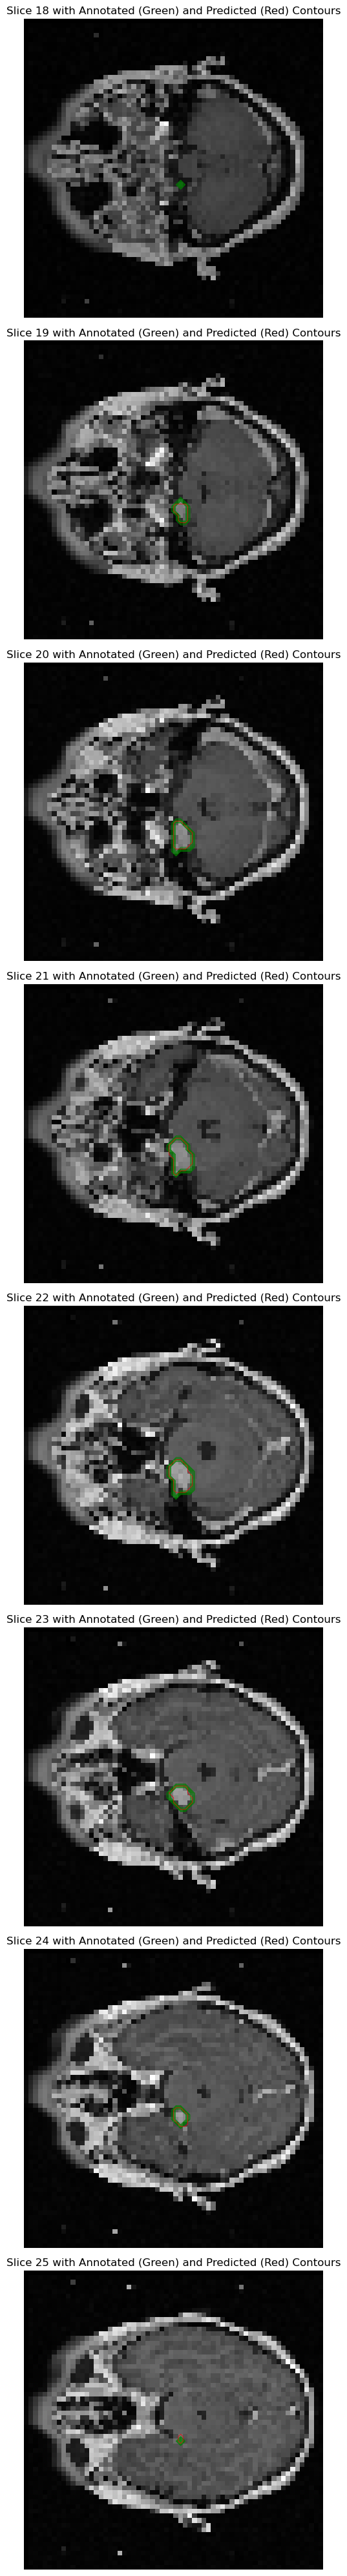

In [24]:
plot_test_image_with_contours(48, X_test, Y_test)
